In this notebook we are checking how much do the different models agree with each other, in terms of specific transfer event inferences

In [1]:
import pandas as pd
import numpy as np
import itertools
import os
from matplotlib import pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import math

compiled_res_dir = '../data/compiled_results/'
plots_dir = '../plots/'

In [2]:
# plt_style_file = 'lib/plot.mplstyle'
# plt.style.use(plt_style_file)
# mpl.rc_file(plt_style_file)
# Scale the relevant rcParams by 1.5x
# Scale the relevant rcParams by 1.5x, but use font_scale_factor for font sizes
scale_factor = 1.5
font_scale_factor = 2.5
for key in mpl.rcParams:
    try:
        if not "size" in key:
            continue
        # Use font_scale_factor if the key is related to font size
        if "font" in key:
            factor = font_scale_factor
        else:
            factor = scale_factor
        if isinstance(mpl.rcParams[key], (int, float)) and not isinstance(
            mpl.rcParams[key], bool
        ):
            mpl.rcParams[key] *= factor
        elif isinstance(mpl.rcParams[key], (list, tuple)):
            mpl.rcParams[key] = [
                (
                    v * factor
                    if isinstance(v, (int, float)) and not isinstance(v, bool)
                    else v
                )
                for v in mpl.rcParams[key]
            ]
    except Exception as e:
        print(f"Error scaling {key} from {mpl.rcParams[key]}: {e}")
        raise e

# set global serif font
mpl.rcParams['font.family'] = 'serif'

import json

# read in the marker styles
with open("lib/plot_marker_styles.json", "r") as fh:
    marker_styles_dict = json.load(fh)["marker_styles_dict"]
    # this is a dictionary such that for each method it contains
    # a dict of marker styles for 'marker_pyplot', 'marker_plotly', 'marker_color', 'face_color', 'label'

In [3]:
# this script calculates the intersections for each pair of methods, for each combination of thresholds
# it also calculates the number of transfers for each method, for each threshold

def is_float(value):
    try:
        float(value)
    except ValueError:
        return False
    return True


# first we read in all the compiled nogwise branchwise transfer data
transfer_filepaths = []
for root, dirs, files in os.walk(compiled_res_dir):
    for f in files:
        if f.startswith('compiled_transfers.nogwise.branchwise'):
            transfer_filepaths.append(os.path.join(root, f))
# read them into dfs, stored in a dict with the method name as the key
# for a filename, split it by period character, and take everything after the third period. Then remove everything after the last period
transfer_dfs = {f[f.find('compiled_transfers.nogwise.branchwise.') + len('compiled_transfers.nogwise.branchwise.'):f.find('.tsv')]:
                pd.read_csv(f,
                            sep='\t', header=0, 
                            ) for f in transfer_filepaths
}

# for each of these dfs, create a column 'source-recipient' combining the source and recipient columns
for method, df in transfer_dfs.items():
    if 'source_branch' in df.columns:
        df['source_branch'] = df['source_branch'].astype(str)
    else:
        df['source_branch'] = 'unknown'
    df['recipient_branch'] = df['recipient_branch'].astype(str)
    df['source-recipient'] = df['source_branch'] + '-' + df['recipient_branch']

# check the unique 'method' values. 
# if there's values that have a number at the end, these are the thresholds
# we combine these methods into one, and add a column 'transfer_threshold' with the threshold value
method_names = []
manual_threshold_methods = {}
for method in transfer_dfs.keys():
    if is_float(method.split('.')[-1]):
        # this is a threshold
        method_splits = method.split('.')
        method_name = '.'.join([s for s in method_splits if not is_float(s)])
        transfer_threshold = float('.'.join([s for s in method_splits if is_float(s)]))
        if method_name not in manual_threshold_methods:
            manual_threshold_methods[method_name] = {}
        manual_threshold_methods[method_name][transfer_threshold] = method
    else:
        # this is a method name
        method_names.append(method)

for method_name, thr_dict in manual_threshold_methods.items():
    combined_df = pd.concat([transfer_dfs[method].assign(transfer_threshold=thr) for thr, method in thr_dict.items()], ignore_index=True)
    transfer_dfs[method_name] = combined_df
    for method in thr_dict.values():
        del transfer_dfs[method]
print(f"List of methods: {list(transfer_dfs.keys())}")
print(f"List of manual threshold methods: {[k for k in manual_threshold_methods.keys()]}")

# we want to calculate intersections for each pair of methods
# this results in a df with columns 'method1', 'method2', 'method1_threshold', 'method2_threshold', 'jaccard_index', ...
# if the total number of unique values in 'transfers' is just 1, (e.g. in case of angst),
# we just do the calculation for the threshold 1.0 for that method, but across thresholds for the other method
# unless both of them have only 1 unique value, in which case we just do the calculation once
intersections_dfs = []
method_pairs = list(itertools.combinations(transfer_dfs.keys(), 2))


List of methods: ['count.mp', 'gloome.ml', 'gloome.ml.without_tree', 'angst', 'ale', 'ranger', 'ranger-fast', 'count.ml', 'wn', 'gloome.mp', 'gloome.mp.without_tree']
List of manual threshold methods: ['gloome.mp', 'gloome.mp.without_tree', 'count.mp']


The following takes a few minutes to run

In [4]:
manual_threshold_methods_list = list(manual_threshold_methods.keys())

for method1, method2 in tqdm(method_pairs, desc='Calculating intersections', total=len(method_pairs)):
    # get the unique values in the transfer_threshold column for each method
    thresholds1 = transfer_dfs[method1]['transfer_threshold'].unique() if method1 in manual_threshold_methods_list else \
                  transfer_dfs[method1]['transfers'].unique() if method1 == 'wn' else \
                  [1.0] if sum(transfer_dfs[method1]['transfers'].unique() <= 1) == 1 else np.arange(0, 1.1, 0.1)
    thresholds2 = transfer_dfs[method2]['transfer_threshold'].unique() if method2 in manual_threshold_methods_list else \
                    transfer_dfs[method2]['transfers'].unique() if method2 == 'wn' else \
                  [1.0] if sum(transfer_dfs[method2]['transfers'].unique() <= 1) == 1 else np.arange(0, 1.1, 0.1)
    

    # for each combination of thresholds, calculate the intersections
    # if either of the methods has only 1 unique value, only the recipient branches are compared instead of the source-recipient branches
    for threshold1 in thresholds1:
        for threshold2 in thresholds2:
            if len(thresholds1) == 1 or len(thresholds2) == 1:
                branch_label = 'recipient_branch'
            else:
                branch_label = 'source-recipient'
            set1 = set(transfer_dfs[method1][transfer_dfs[method1]
                       ['transfer_threshold'] == threshold1][branch_label]) if method1 in manual_threshold_methods_list else \
                set(transfer_dfs[method1][transfer_dfs[method1]
                       ['transfers'] == threshold1][branch_label]) if method1 == 'wn' else \
                set(transfer_dfs[method1][transfer_dfs[method1]
                       ['transfers'] >= threshold1][branch_label])
            set2 = set(transfer_dfs[method2][transfer_dfs[method2]
                       ['transfer_threshold'] == threshold2][branch_label]) if method2 in manual_threshold_methods_list else \
                set(transfer_dfs[method2][transfer_dfs[method2]
                       ['transfers'] == threshold2][branch_label]) if method2 == 'wn' else \
                set(transfer_dfs[method2][transfer_dfs[method2]
                       ['transfers'] >= threshold2][branch_label])
            
            if len(set1) == 0:
                # print(f"Warning: {method1} has no transfers for threshold {threshold1}")
                continue
            if len(set2) == 0:
                # print(f"Warning: {method2} has no transfers for threshold {threshold2}")
                continue
            set_union = len(set1.union(set2))
            set_intersection = len(set1.intersection(set2))
            branch_type = 'source-recipient' if branch_label == 'source-recipient' else 'recipient'            

            jaccard_index = len(set1.intersection(set2)) / \
                len(set1.union(set2))
            overlap_coefficient = len(
                set1.intersection(set2)) / min(len(set1), len(set2))

            method1_transfers = len(set1); method2_transfers = len(set2)

            intersections_dfs.append(pd.DataFrame({'method1': method1, 'method2': method2,
                                             # the thresholds for each method should be written without too many decimal places
                                             'method1_threshold': round(threshold1, 1), 'method2_threshold': round(threshold2, 1),
                                             # number of transfers for method1 and method2, for the given thresholds
                                             'method1_transfers': method1_transfers, 'method2_transfers': method2_transfers,
                                                'branch_type': branch_type, 
                                                'set_union': set_union, 'set_intersection': set_intersection,
                                             'jaccard_index': jaccard_index, 'overlap_coefficient': overlap_coefficient,
                                             }, index=[0]))
# now we have a list of dfs, we can concatenate them into one df
intersections_df = pd.concat(intersections_dfs)
# show the df
display(intersections_df)
# write the df to a file
intersections_df.to_csv(os.path.join(compiled_res_dir, 'intersections.nogwise.branchwise.tsv'),
                  sep='\t', index=False)

Calculating intersections:   0%|          | 0/55 [00:00<?, ?it/s]

Calculating intersections: 100%|██████████| 55/55 [02:54<00:00,  3.17s/it]


,method1,method2,method1_threshold,method2_threshold,method1_transfers,method2_transfers,branch_type,set_union,set_intersection,jaccard_index,overlap_coefficient
0,count.mp,gloome.ml,0.5,0.0,702,706,source-recipient,714,694,0.971989,0.988604
0,count.mp,gloome.ml,0.5,0.1,702,698,source-recipient,713,687,0.963534,0.984241
0,count.mp,gloome.ml,0.5,0.2,702,686,source-recipient,712,676,0.949438,0.985423
0,count.mp,gloome.ml,0.5,0.3,702,676,source-recipient,710,668,0.940845,0.988166
0,count.mp,gloome.ml,0.5,0.4,702,662,source-recipient,710,654,0.921127,0.987915
...,...,...,...,...,...,...,...,...,...,...,...
0,gloome.mp,gloome.mp.without_tree,8.0,4.0,156,686,source-recipient,686,156,0.227405,1.000000
0,gloome.mp,gloome.mp.without_tree,8.0,5.0,156,673,source-recipient,675,154,0.228148,0.987179
0,gloome.mp,gloome.mp.without_tree,8.0,6.0,156,658,source-recipient,662,152,0.229607,0.974359
0,gloome.mp,gloome.mp.without_tree,8.0,8.0,156,604,source-recipient,614,146,0.237785,0.935897


# Plot figures

In [5]:
# read in the intersections df
intersections_df = pd.read_csv(os.path.join(compiled_res_dir, 'intersections.nogwise.branchwise.tsv'),
                         sep='\t')

methods_list = list(
    set(intersections_df["method1"].unique()).union(
        set(intersections_df["method2"].unique())
    )
)
print(f"methods_list: {methods_list}")

methods_list: ['wn', 'gloome.mp.without_tree', 'gloome.ml', 'gloome.ml.without_tree', 'ale', 'count.ml', 'ranger-fast', 'ranger', 'angst', 'gloome.mp', 'count.mp']


## Overlap Coefficient

methods_list: ['wn', 'gloome.mp.without_tree', 'gloome.ml', 'gloome.ml.without_tree', 'ale', 'count.ml', 'ranger-fast', 'ranger', 'angst', 'gloome.mp', 'count.mp']
multi_threshold_methods_list: ['ale', 'count.ml', 'count.mp', 'gloome.ml', 'gloome.ml.without_tree', 'gloome.mp', 'gloome.mp.without_tree', 'ranger', 'ranger-fast', 'wn']
ncols: 10, nrows: 10, nsubplots: 100


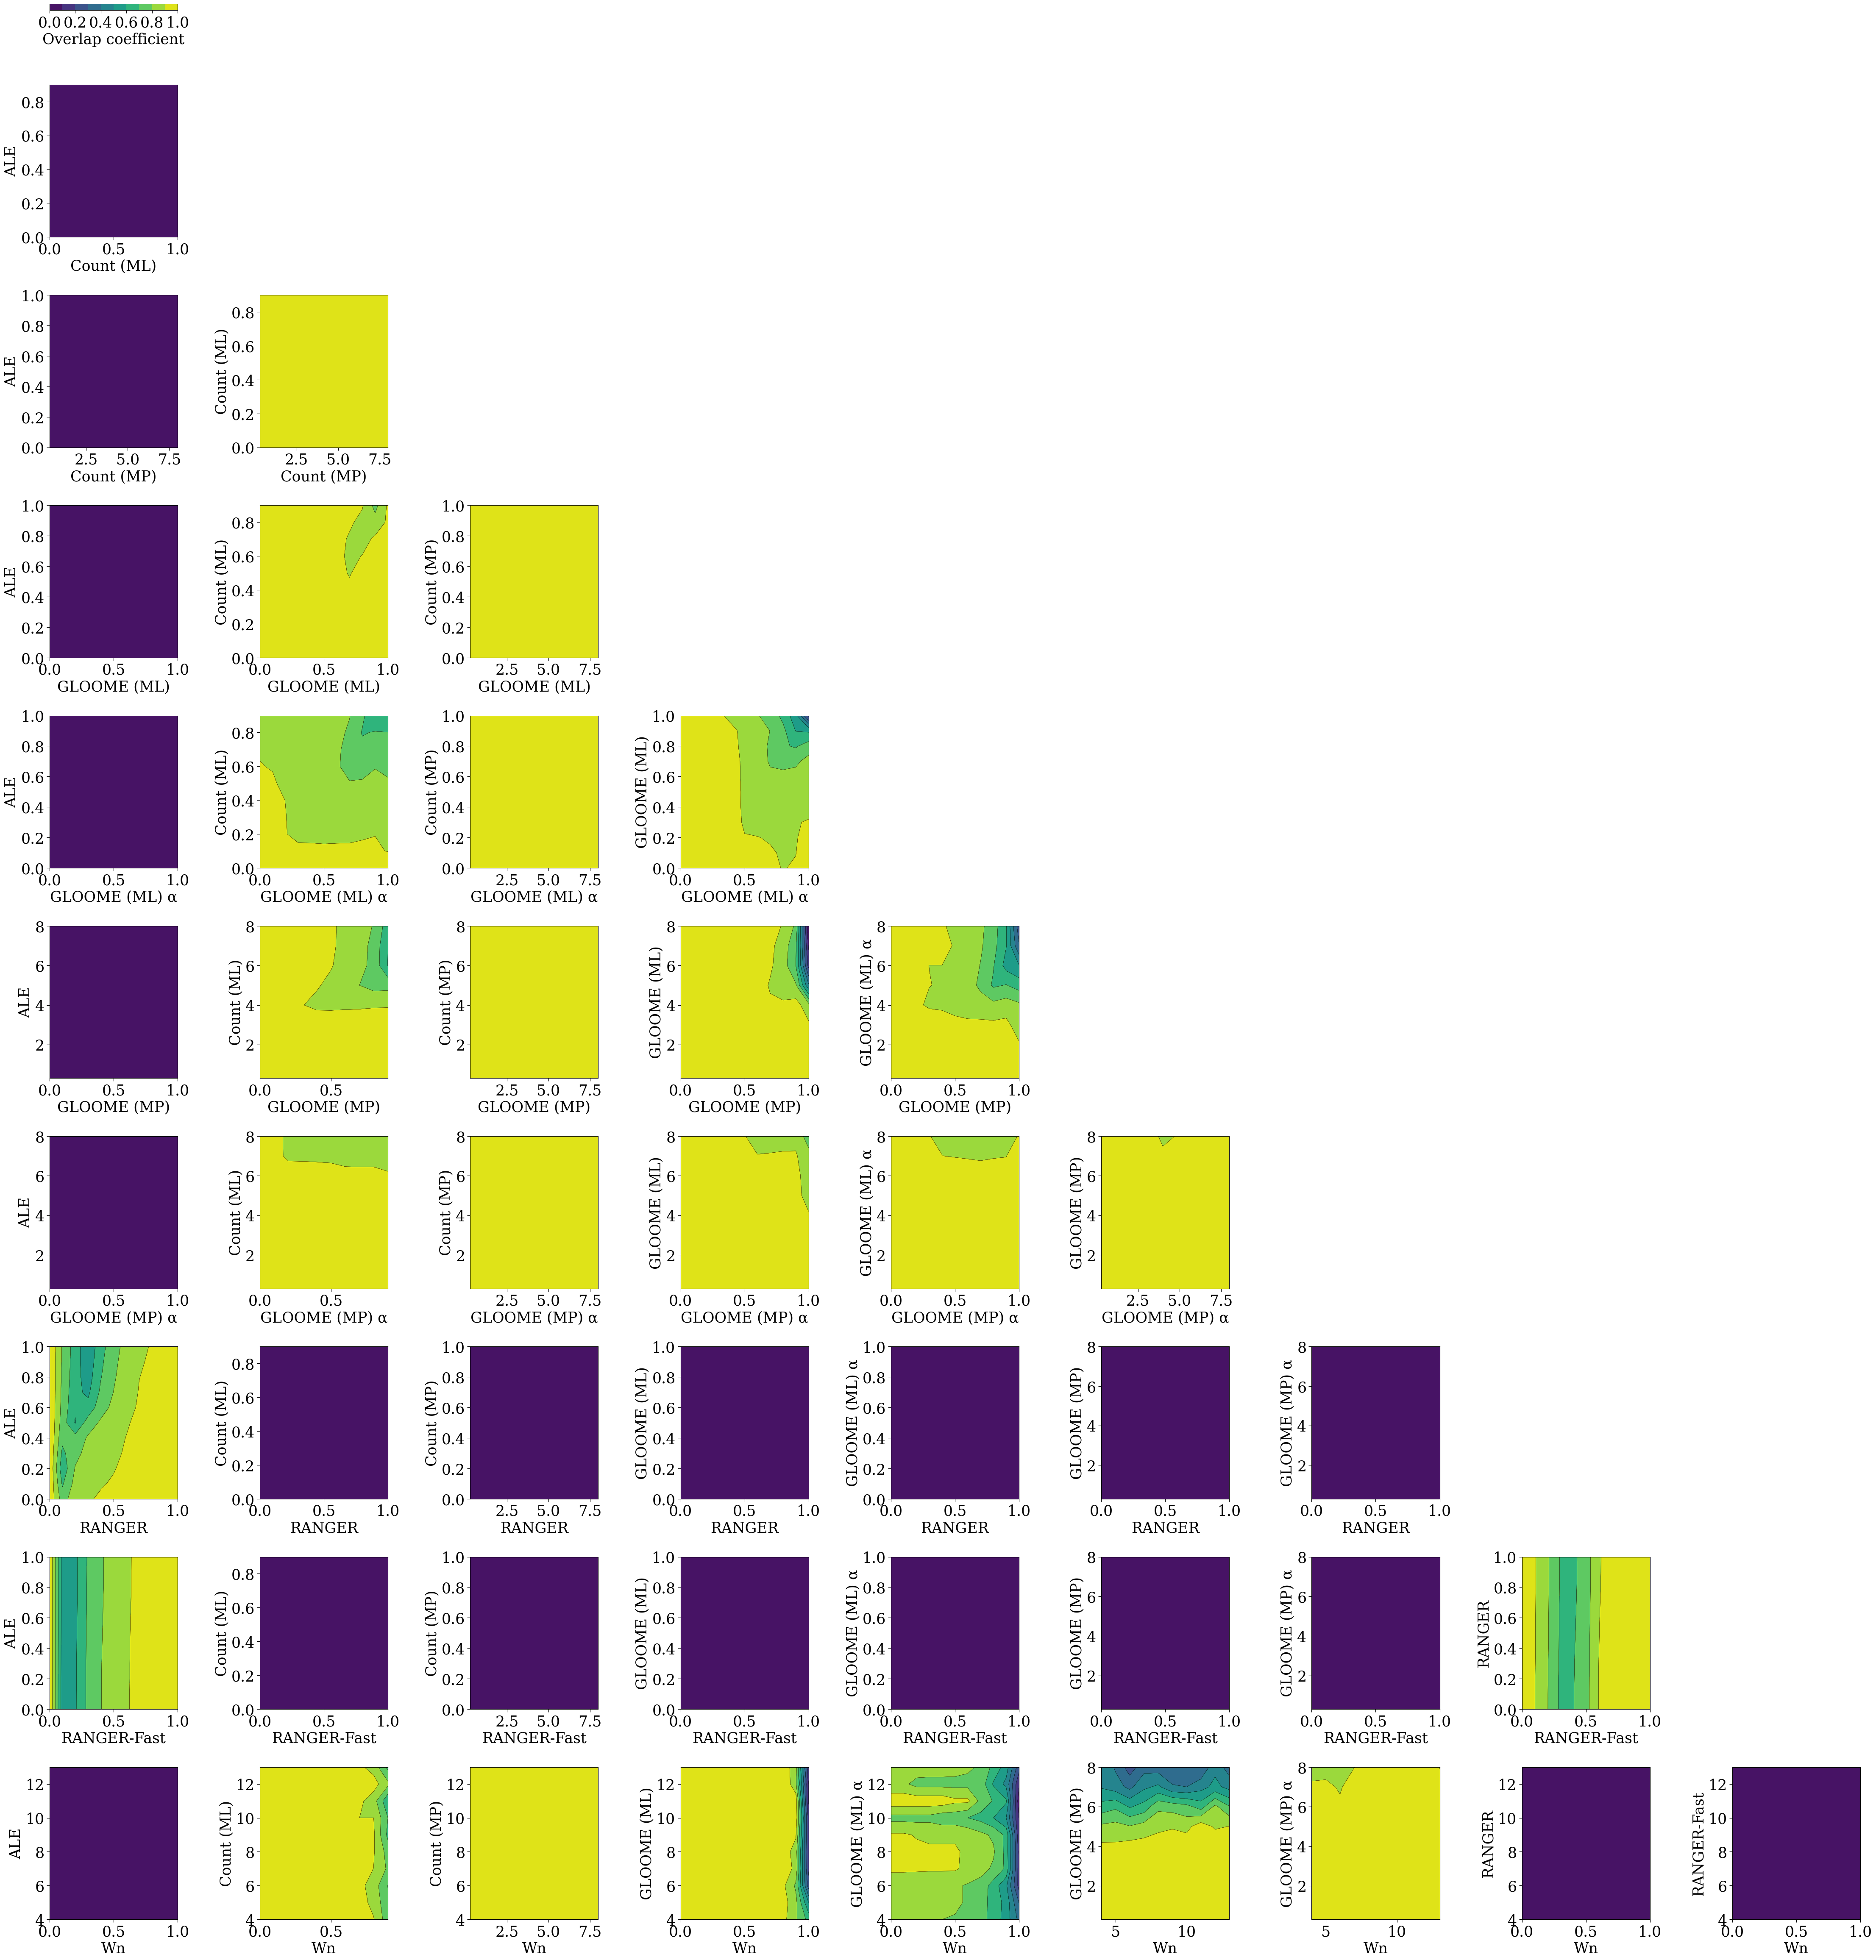

Plotting angst vs ale at (0, 0)
Plotting angst vs count.ml at (0, 1)
Plotting angst vs count.mp at (0, 2)
Plotting angst vs gloome.ml at (1, 0)
Plotting angst vs gloome.ml.without_tree at (1, 1)
Plotting angst vs gloome.mp at (1, 2)
Plotting angst vs gloome.mp.without_tree at (2, 0)
Plotting angst vs ranger at (2, 1)
Plotting angst vs ranger-fast at (2, 2)
Plotting angst vs wn at (3, 0)


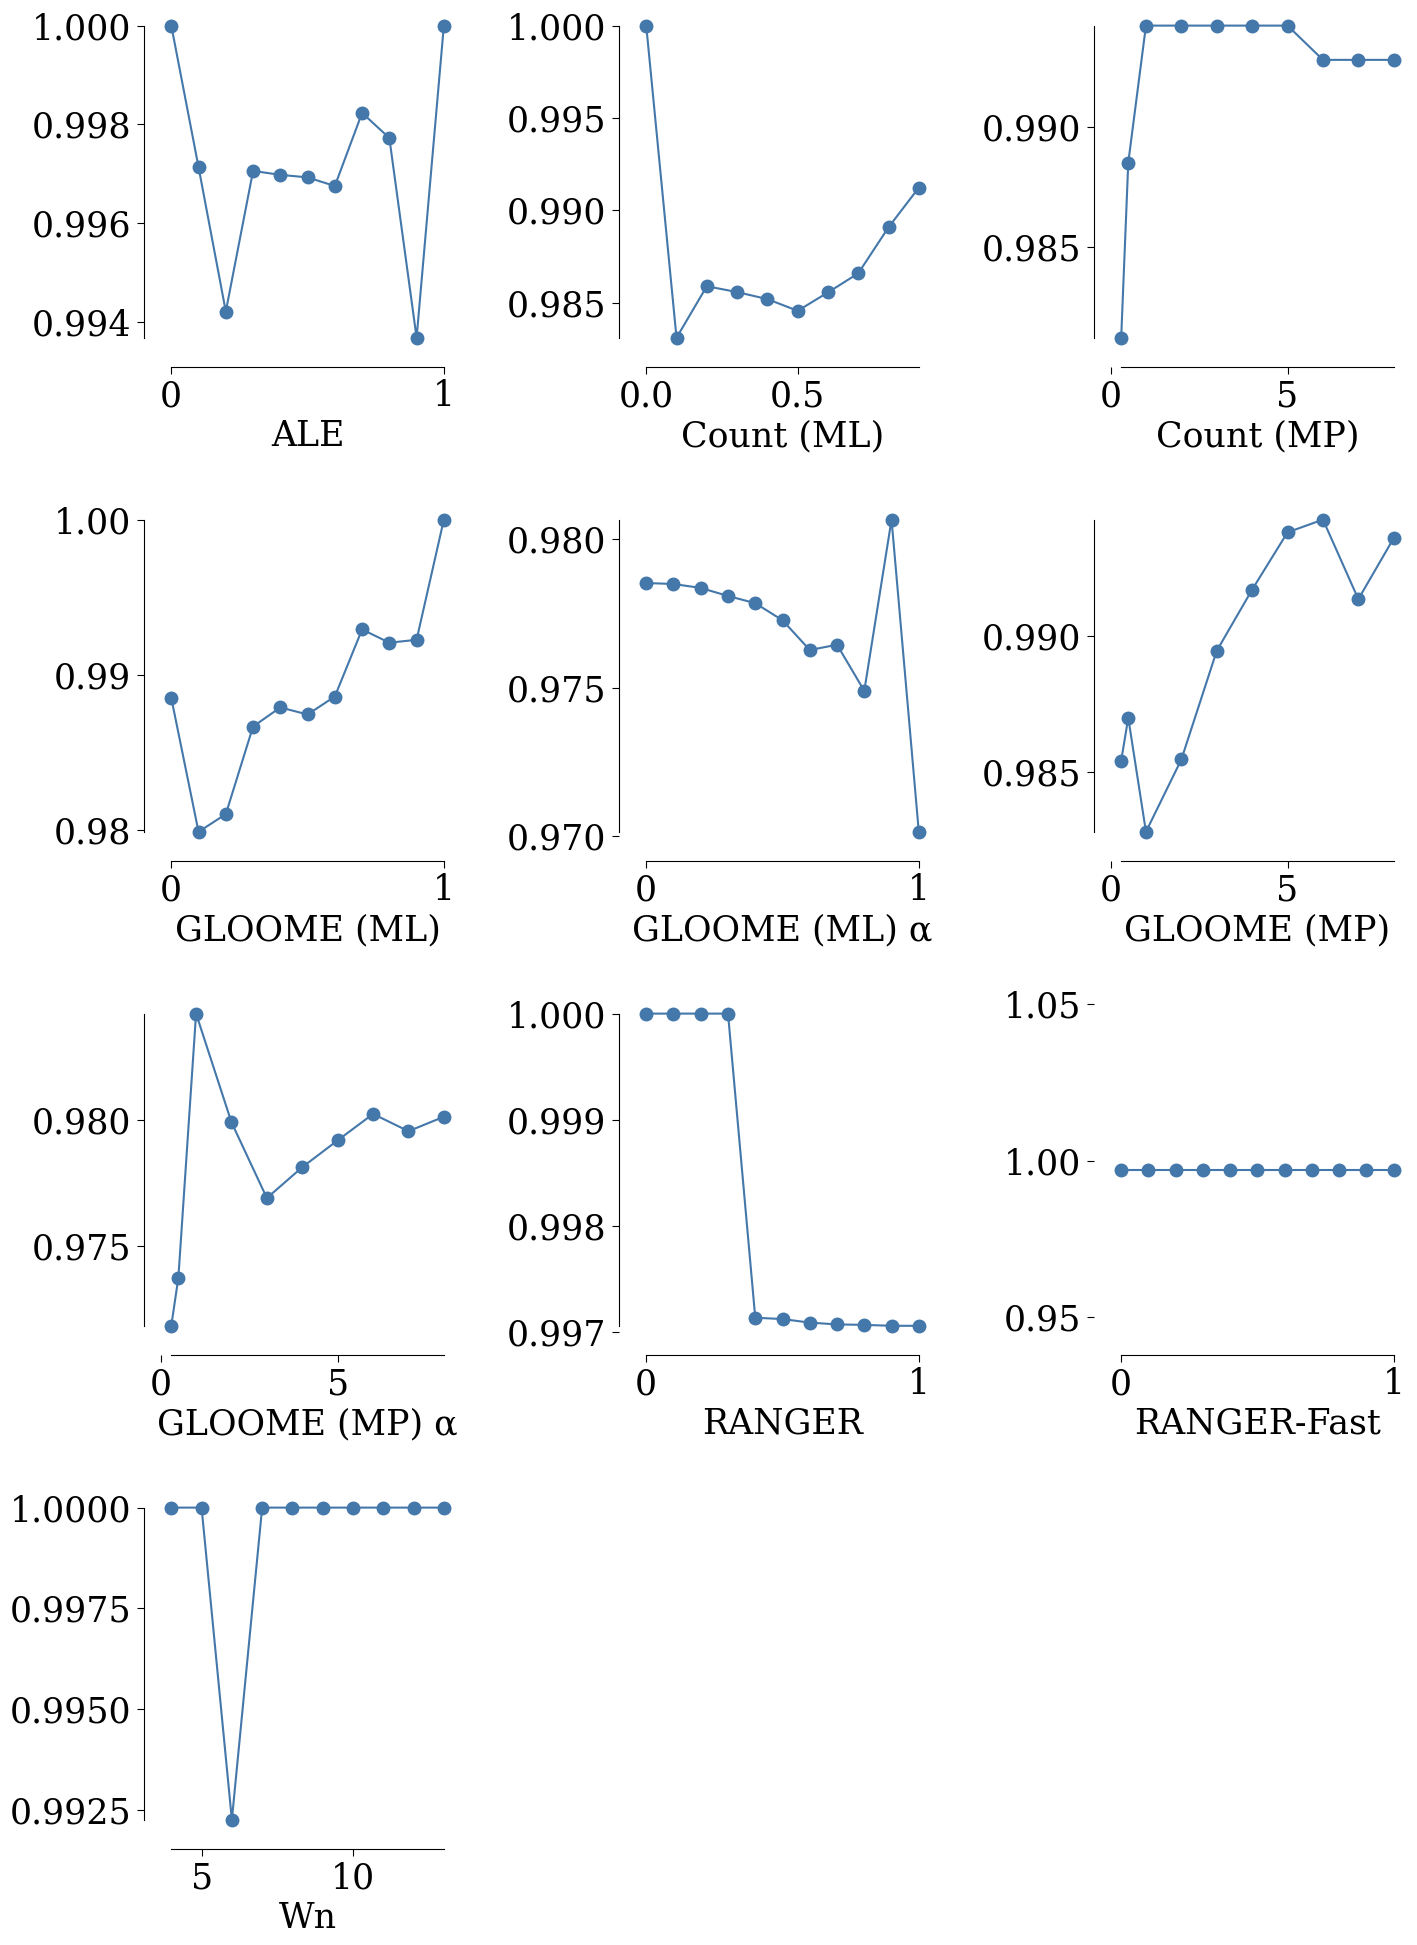

In [6]:
# set up the subplots as a matrix of each pair of methods. Diagonals are empty, and if a (a,b) subplot exists, (b,a) is empty (i.e. we only show half of the matrix)
methods_list = list(
    set(intersections_df["method1"]).union(set(intersections_df["method2"]))
)
print(f"methods_list: {methods_list}")

single_threshold_methods_list = [
    method
    for method in methods_list
    if intersections_df[intersections_df["method1"] == method]["method1_threshold"].nunique() == 1
    or intersections_df[intersections_df["method2"] == method]["method2_threshold"].nunique() == 1
]
single_threshold_methods_list = list(set(single_threshold_methods_list))

multi_threshold_methods_list = [
    method
    for method in methods_list
    if intersections_df[intersections_df["method1"] == method]["method1_threshold"].nunique() > 1
    or intersections_df[intersections_df["method2"] == method]["method2_threshold"].nunique() > 1
]
multi_threshold_methods_list = sorted(set(multi_threshold_methods_list))
print(f"multi_threshold_methods_list: {multi_threshold_methods_list}")

# matrix of subplots, for contour plots of each pair of multi-threshold methods
ncols = len(multi_threshold_methods_list)
nrows = len(multi_threshold_methods_list)
nsubplots = ncols * nrows
print(f"ncols: {ncols}, nrows: {nrows}, nsubplots: {nsubplots}")

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
for method1, method2 in itertools.product(
    multi_threshold_methods_list, multi_threshold_methods_list
):
    if method1 == method2:
        continue
    # get the overlap coefficients for the pair of methods
    # check if the pair of methods in this order exists in the df
    if (
        len(
            intersections_df[
                (intersections_df["method1"] == method1)
                & (intersections_df["method2"] == method2)
            ]
        )
        > 0
    ):
        this_df = intersections_df[
            (intersections_df["method1"] == method1)
            & (intersections_df["method2"] == method2)
        ]
    else:
        this_df = intersections_df[
            (intersections_df["method1"] == method2)
            & (intersections_df["method2"] == method1)
        ]
    # if the df is empty, skip
    if this_df.empty:
        continue

    # sort by thresholds
    this_df = this_df.sort_values(
        by=["method1_threshold", "method2_threshold"], ascending=[True, True]
    )

    # plot the overlap coefficients as a contour plot
    X, Y = np.meshgrid(
        this_df["method1_threshold"].unique(), this_df["method2_threshold"].unique()
    )
    Z = this_df.pivot(
        index="method2_threshold",
        columns="method1_threshold",
        values="overlap_coefficient",
    )
    # plot the contour plot
    row = multi_threshold_methods_list.index(method1)
    col = multi_threshold_methods_list.index(method2)
    if row < col:
        row = multi_threshold_methods_list.index(method2)
        col = multi_threshold_methods_list.index(method1)
    ax = axs[row, col]
    cs = ax.contourf(X, Y, Z, levels=np.arange(0, 1.1, 0.1), cmap="viridis")
    # plot contour lines also and set the labels
    ax.contour(
        X,
        Y,
        Z,
        levels=np.arange(0, 1.1, 0.1),
        colors="black",
        # thin contour lines
        linewidths=0.25,
    )
    ax.set_xlabel(marker_styles_dict[method1]["label"])
    ax.set_ylabel(marker_styles_dict[method2]["label"])
# add a colorbar
fig.colorbar(cs, ax=axs[0, 0], orientation="horizontal", label="Overlap coefficient")
plt.tight_layout()

# delete the empty subplots
for ax in axs:
    for a in ax:
        if not a.has_data():
            a.remove()

plt.show()

# save jpg
fig.savefig(
    os.path.join(plots_dir, "intersections.nogwise.branchwise.contour_plots.jpg"),
    format="jpg",
    bbox_inches="tight",
    dpi=300,
)

#################################################################################################################################################

all_method_pairs = list(
    itertools.product(single_threshold_methods_list, multi_threshold_methods_list)
)
nrows = math.ceil(math.sqrt(len(all_method_pairs)))
ncols = math.ceil(len(all_method_pairs) / nrows)
nsubplots = ncols * nrows
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
for idx, method_pair in enumerate(all_method_pairs):
    method1, method2 = method_pair
    # check which of the methods is the single-threshold method
    if method1 in single_threshold_methods_list:
        single_threshold_method = method1
        multi_threshold_method = method2
    else:
        single_threshold_method = method2
        multi_threshold_method = method1
    # either the single-threshold method or the multi-threshold method should be in the method1 column
    if (
        len(
            intersections_df[
                (intersections_df["method1"] == single_threshold_method)
                & (intersections_df["method2"] == multi_threshold_method)
            ]
        )
        > 0
    ):
        this_df = intersections_df[
            (intersections_df["method1"] == single_threshold_method)
            & (intersections_df["method2"] == multi_threshold_method)
        ]
        x = "method2_threshold"
    else:
        this_df = intersections_df[
            (intersections_df["method1"] == multi_threshold_method)
            & (intersections_df["method2"] == single_threshold_method)
        ]
        x = "method1_threshold"
    y = "overlap_coefficient"

    # sort by thresholds
    this_df = this_df.sort_values(
        by=["method1_threshold", "method2_threshold"], ascending=[True, True]
    )

    # figure out the index of the subplot using the idx
    row = idx // ncols
    col = idx % ncols
    print(f"Plotting {single_threshold_method} vs {multi_threshold_method} at ({row}, {col})")
    ax = axs[row, col]
    # we plot the overlap coefficients with x as thresholds of multi-threshold method, and y as overlap coefficients
    ax.plot(this_df[x], this_df[y], marker="o", linestyle="-", color="#4477AA")
    ax.set_xlabel(marker_styles_dict[multi_threshold_method]["label"])
    # ax.set_ylabel(f"Overlap coefficient vs {marker_styles_dict[single_threshold_method]['label']}")
    ax.set_ylabel("")
    

    # Tufte style
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # move the left and bottom spines away from the data
    ax.spines["left"].set_position(("outward", 10))  # outward by 10 points
    ax.spines["bottom"].set_position(("outward", 10))  # outward by 10 points
    # set spine bounds to be same as data limits
    ax.spines["left"].set_bounds(
        this_df[y].min(), this_df[y].max()
    )  # set the y limits to the data limits
    ax.spines["bottom"].set_bounds(
        this_df[x].min(), this_df[x].max()
    )  # set the x limits to the data limits

plt.tight_layout()
# delete the empty subplots
for ax in axs:
    for a in ax:
        if not a.has_data():
            a.remove()
plt.show()
# save jpg
fig.savefig(
    os.path.join(plots_dir, "intersections.nogwise.branchwise.line_plots.jpg"),
    format="jpg",
    bbox_inches="tight",
    dpi=300,
)

In [7]:
# make a new summary df with the max overlap coefficient and max jaccard index for each pair of methods
# first we get the max overlap coefficient for each pair of methods
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from numpy import square
import warnings
summary_overlap_df = pd.DataFrame()
for method1, method2 in method_pairs:
    if len(intersections_df[(intersections_df['method1'] == method1) & (intersections_df['method2'] == method2)]) > 0:
         this_df = intersections_df[(intersections_df['method1'] == method1) & (
            intersections_df['method2'] == method2)]
    else:
        this_df = intersections_df[(intersections_df['method1'] == method2) & (
            intersections_df['method2'] == method1)]
    if this_df.empty:
        continue
    max_overlap_coefficient = this_df['overlap_coefficient'].max()
    max_jaccard_index = this_df['jaccard_index'].max()
    min_overlap_coefficient = this_df['overlap_coefficient'].min()
    min_jaccard_index = this_df['jaccard_index'].min()
    # concatenate the max overlap coefficient and max jaccard index to the summary_overlap_df as a new row
    this_record = pd.DataFrame({'method1': method1, 'method2': method2,
                                'max_overlap_coefficient': max_overlap_coefficient,
                                'max_jaccard_index': max_jaccard_index,
                                'min_overlap_coefficient': min_overlap_coefficient,
                                'min_jaccard_index': min_jaccard_index
                                }, index=[0])
    summary_overlap_df = pd.concat([summary_overlap_df, this_record])
# sort by method1, method2
summary_overlap_df = summary_overlap_df.sort_values(by=['method1', 'method2'])

# use the summary_overlap_df to make a heirarchical clustering of the methods and plot it as a dendrogram

# some of the pairs have max_overlap_coefficient = 0.0, which is not useful for clustering
# we modify the summary_overlap_df so that the pairs with max_overlap_coefficient = 0.0 have max_overlap_coefficient = 0.0000001

# possible values for linkage_method are: single, complete, average, weighted, centroid, median, ward
linkage_method = 'average'  # UPGMA
optimal_ordering = True
color_threshold = 0.0  # color_threshold is the distance threshold to color the branches

# min_distance = 1e-4

# apply heirarchical clustering to the summary_overlap_df but instead of similarity, we want dissimilarity as the distance metric
summary_overlap_df['1 - max_overlap_coefficient'] = 1 - \
    summary_overlap_df['max_overlap_coefficient']
summary_overlap_df['1 - max_jaccard_index'] = 1 - \
    summary_overlap_df['max_jaccard_index']


# find min_distance as the minimum non-zero value in the combined 1 - max_overlap_coefficient and 1 - max_jaccard_index columns
min_distance = summary_overlap_df[['1 - max_overlap_coefficient',
                               '1 - max_jaccard_index']].replace(0.0, np.nan).min().min()
# round this to lowest power of 10
# min_distance = 10 ** np.floor(np.log10(min_distance))

# if min_distance is 0.0, set it to 1e-10 (small number) to avoid errors
min_distance = 1e-10

print(f'min_distance: {min_distance}')
# replace 0.0 with min_distance
summary_overlap_df['1 - max_overlap_coefficient'] = summary_overlap_df['1 - max_overlap_coefficient'].replace(
    0.0, min_distance)
summary_overlap_df['1 - max_jaccard_index'] = summary_overlap_df['1 - max_jaccard_index'].replace(
    0.0, min_distance)


min_distance: 1e-10


In [8]:
def power_transformation(x, power=0.6):
    try:
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always")
            # sometimes x maybe be < 0, which will result in a runtime warning
            if any(x < 0):
                # first we store the indices where x is < 0
                neg_indices = x < 0
                # then we set x to be the absolute value of x
                x = np.abs(x)
                # then we apply the power transformation
                result = np.power(x, power)
                # then we set the values at the neg_indices to be the negative of the result
                result[neg_indices] = -result[neg_indices]
            else:
                result = np.power(x, power)
            if len(w) > 0:
                print(f"Runtime warning for x: {x}")
                for warning in w:
                    print(warning.message)
            return result
    except Exception as e:
        print(f"Exception for x: {x}")
        raise e


def color_methods(method):
    # colors:  '#004488', '#DDAA33', '#BB5566'
    if marker_styles_dict[method]["paradigm"] == "explicit":
        return "#004488"
    elif marker_styles_dict[method]["paradigm"] == "implicit":
        return "#BB5566"
    elif marker_styles_dict[method]["paradigm"] == "parametric":
        return "#DDAA33"

Dendrograms generated using linkage method:average and distances 1 - max overlap coefficient and 1 - max jaccard index. Note that the x-axis is transformed using a power transformation to make the distances more visible.


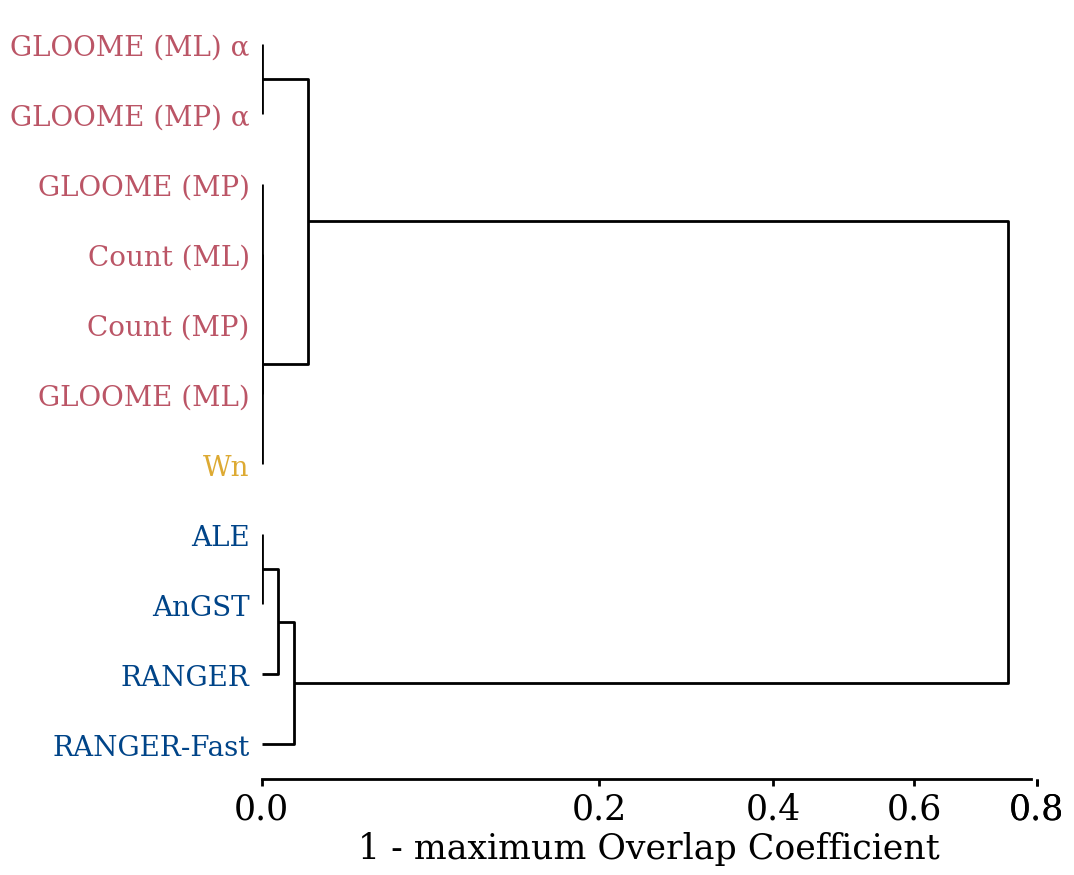

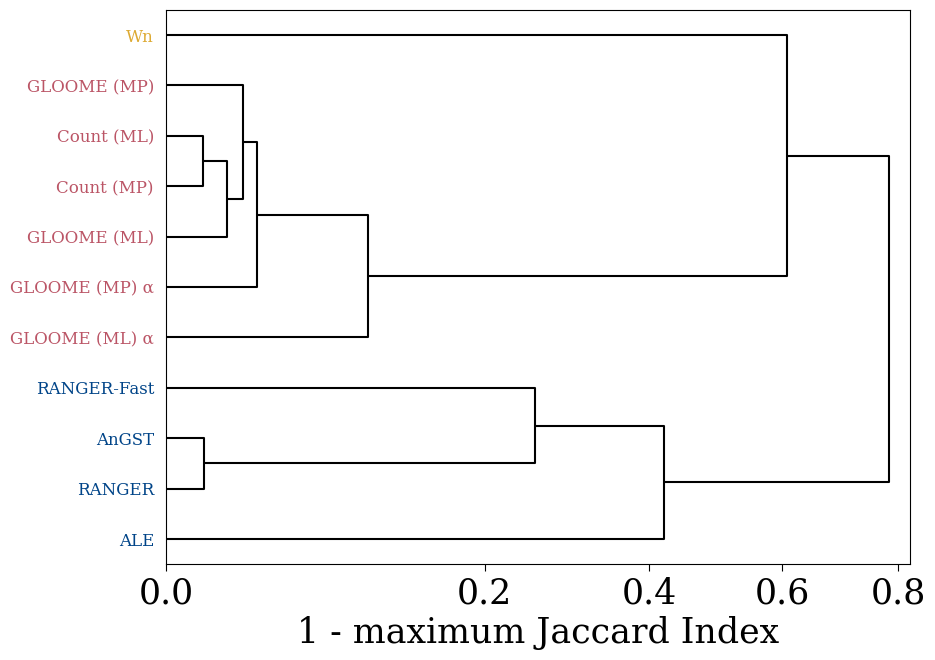

In [9]:

# rename the methods using the marker_styles_dict
method_label_dict = {method: marker_styles_dict[method]['label'] for method in methods_list}
method_label_dict_reverse = {v: k for k, v in method_label_dict.items()}
# summary_overlap_df['method1'] = summary_overlap_df['method1'].map(method_label_dict)
# summary_overlap_df['method2'] = summary_overlap_df['method2'].map(method_label_dict)

# display(summary_overlap_df)

# get the linkage matrix for overlap coefficient
max_overlap_pivot_df = summary_overlap_df.pivot(
    index='method1', columns='method2', values='1 - max_overlap_coefficient')
max_overlap_pivot_df = max_overlap_pivot_df.combine_first(
    max_overlap_pivot_df.T)
np.fill_diagonal(max_overlap_pivot_df.values, 0)
# relabel the methods using the marker_styles_dict
max_overlap_pivot_df.index = max_overlap_pivot_df.index.map(method_label_dict)
Z_overlap = linkage(squareform(max_overlap_pivot_df),
                    method=linkage_method, optimal_ordering=optimal_ordering)
# get the linkage matrix for jaccard index
max_jaccard_pivot_df = summary_overlap_df.pivot(
    index='method1', columns='method2', values='1 - max_jaccard_index')
max_jaccard_pivot_df = max_jaccard_pivot_df.combine_first(
    max_jaccard_pivot_df.T)
np.fill_diagonal(max_jaccard_pivot_df.values, 0)
# relabel the methods using the marker_styles_dict
max_jaccard_pivot_df.index = max_jaccard_pivot_df.index.map(method_label_dict)
Z_jaccard = linkage(squareform(max_jaccard_pivot_df),
                    method=linkage_method, optimal_ordering=optimal_ordering)

# plot the dendrogram
print(f'Dendrograms generated using linkage method:{
      linkage_method} and distances 1 - max overlap coefficient and 1 - max jaccard index. Note that the x-axis is transformed using a power transformation to make the distances more visible.')

fig1 = plt.figure(figsize=(10, 10))
# replace zeros in Z_overlap with min_distance
Z_overlap[Z_overlap == 0.0] = min_distance
with plt.rc_context(rc={'lines.linewidth': 2}):
    d = dendrogram(Z_overlap, orientation='right', labels=max_overlap_pivot_df.index,
           color_threshold=color_threshold,
           above_threshold_color='black',
           )
plt.xlabel('1 - maximum Overlap Coefficient')
ax = plt.gca(); axlbs = ax.get_ymajorticklabels()
for label in axlbs:
    # label.set_color(color_methods(label.get_text()))
    this_label_color = color_methods(method_label_dict_reverse[label.get_text()])
    label.set_color(this_label_color) # type: ignore

# increase xlabel size
plt.yticks(fontsize=20)
ax.set_xscale('function', functions=(power_transformation, power_transformation))
# ax.set_xlim(-0.01, ax.get_xlim()[1])
# Tufte style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# set bottom spine bounds to be same as data limits
ax.spines['bottom'].set_bounds(
    0, ax.get_xlim()[1])  # set the x limits to the data limits
# set x ticks for both of these bounds if not already set
x_ticks = ax.get_xticks()
if 0 not in x_ticks:
    x_ticks = np.append(x_ticks, 0)
if ax.get_xlim()[1] not in x_ticks:
    x_ticks = np.append(x_ticks, ax.get_xlim()[1])
x_ticks = np.round(x_ticks, 1)  # Round the labels to the nearest 0.1
ax.set_xticks(x_ticks)

# increase thickness of spines and ticks
ax.tick_params(axis='x', width=2)
ax.tick_params(axis='y', width=2)
ax.spines['bottom'].set_linewidth(2)

plt.show()

fig2 = plt.figure()
dendrogram(Z_jaccard, orientation='right', labels=max_jaccard_pivot_df.index,
           color_threshold=color_threshold,
           above_threshold_color='black')
plt.xlabel('1 - maximum Jaccard Index')
plt.xscale('function', functions=(power_transformation, power_transformation))
ax = plt.gca(); axlbs = ax.get_ymajorticklabels()
for label in axlbs:
    # label.set_color(color_methods(label.get_text()))
    this_label_color = color_methods(method_label_dict_reverse[label.get_text()])
    label.set_color(this_label_color) # type: ignore
plt.show()

# save figures as jpg
fig1.savefig(os.path.join(plots_dir, 'dendrogram_max_overlap_coefficient.jpg'),
            format='jpg', bbox_inches='tight', dpi=300)
fig2.savefig(os.path.join(plots_dir, 'dendrogram_max_jaccard_index.jpg'))